# FIRST LAB ACTIVITY - 01_EPSS


## DISCLAMER:


The Python code in this notebook was primarily inspired by the material provided by Prof. Renda in the 01_EPSS_Material/Python_material/ folder and was largely developed with the assistance of a language model (specifically, ChatGPT). This approach was taken due to my limited programming proficiency in Python. However, I am confident in my ability to read and understand code, and any errors present in the provided or used code are solely my responsibility.

# Initial setup

The initial setup involved importing the core libraries along with other necessary resources.

In [4]:
import pandas as pd
import numpy as np
import os
import requests
import json

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

In [6]:
from preprocessing_utils import preprocess_NVD_data

In [7]:
data_path = 'data'
if not os.path.exists(data_path):
    os.makedirs(data_path)

Subsequently, the EPSS data corresponding to October 1, 2025, was downloaded from https://www.first.org/epss/data_stats and the file epss_scores-2025-10-01.csv.gz was saved in the designated data folder.

Now execute the following command:

In [8]:
epss_current = pd.read_csv(os.path.join(data_path, 'epss_scores-2025-10-01.csv.gz'), compression='gzip', header=1)
epss_current # a Python statement with a variable name at the end of a cell will display its contents below

,cve,epss,percentile
0,CVE-1999-0001,0.01141,0.77780
1,CVE-1999-0002,0.10742,0.93087
2,CVE-1999-0003,0.90362,0.99589
3,CVE-1999-0004,0.03215,0.86596
4,CVE-1999-0005,0.25334,0.96035
...,...,...,...
296328,CVE-2025-9994,0.00060,0.19138
296329,CVE-2025-9996,0.00179,0.40027
296330,CVE-2025-9997,0.00182,0.40386
296331,CVE-2025-9998,0.00023,0.04753


# NVD data retrieval

We now retrieve the CVE (Common Vulnerabilities and Exposures) data from the NVD (National Vulnerability Database) REST API for a specified date range (from September 1, 2025 to October 1, 2025) and we store the results in a list called all_cves.

In [9]:
base_url = "https://services.nvd.nist.gov/rest/json/cves/2.0"
date_start_NVD = '2025-09-01T00:00:00.000Z' # Do NOT change these dates
date_end_NVD   = '2025-10-01T00:00:00.000Z' # Do NOT change these dates
start_index = 0
results_per_page = 1000
total_results = 1 

all_cves = []

while start_index < total_results:
    params = {
        "pubStartDate": date_start_NVD,
        "pubEndDate": date_end_NVD,
        "resultsPerPage": results_per_page,
        "startIndex": start_index,
        "noRejected": ""
    }
    response = requests.get(base_url, params=params, timeout=6)
    if response.status_code != 200:
        print("Error:", response.status_code)
        break

    data = response.json()
    total_results = data.get("totalResults", 0)

    all_cves.extend(data.get("vulnerabilities", []))

    start_index += results_per_page
    print(start_index)

1000
2000
3000
4000
5000


The subsequent code blocks were executed to preprocess the data. This involved transforming the JSON objects into a flattened Pandas DataFrame and performing initial cleaning. Unnecessary CVEs, which did not provide relevant information, were then removed. Following this, the NVD and EPSS datasets were merged, and both the original and processed data were saved for further analysis.

In [10]:
# normalize and preprocess data
df = pd.json_normalize(all_cves, record_path=None, sep='.', max_level=None)
df = preprocess_NVD_data(df)

# remove vulnerabilities marked as "reject" or "reserved"
df = df[(df['cve.vulnStatus']!='Reserved') & (df['cve.vulnStatus']!='Reject')]

# merge NVD and EPSS data
df = df.merge(epss_current, left_on="cve.id", right_on="cve", how="left")

In [11]:
# save nvd data
with open(os.path.join(data_path, "nvd_cves.json"), "w", encoding="utf-8") as f:
    json.dump(all_cves, f, indent=2)
    
# save the final dataframe
df.to_csv(os.path.join(data_path, "vuln_2025_09.csv"))

# Exploratory Data Analysis

Next, all column names were listed to provide an overview of the dataset and understand the features available for analysis.

In [12]:
print(df.columns)


Index(['cve.id', 'cve.sourceIdentifier', 'cve.published', 'cve.lastModified',
       'cve.vulnStatus', 'cve.references', 'cve.cisaExploitAdd',
       'cve.cisaActionDue', 'cve.cisaRequiredAction',
       'cve.cisaVulnerabilityName', 'description', 'vulnerable_cpes',
       'num_references', 'cwe_list', 'cvss_version', 'cvss_vectorString',
       'cvss_baseScore', 'cvss_baseSeverity', 'cvss_attackVector',
       'cvss_attackComplexity', 'cvss_privilegesRequired',
       'cvss_userInteraction', 'cvss_scope', 'cvss_confidentialityImpact',
       'cvss_integrityImpact', 'cvss_availabilityImpact', 'cve', 'epss',
       'percentile'],
      dtype='object')


Several columns of potential interest were identified for further exploration, including:
- cve.id
- cve.sourceIdentifier (Organization/vendor that submitted or maintains the CVE entry)
- cve.references (List of URLs or external sources related to the vulnerability)
- num_references (Number of reference links included in the CVE entry)
- cve.cisaActionDue (Deadline by which federal agencies must mitigate the vulnerability)
- cve.cisaVulnerabilityName (human readable)
- description
- cwe_list (List of Common Weakness Enumeration IDs describing the underlying weakness)
- cvss_baseScore (numeric severity score)
- cvss_baseSeverity (Severity rating i.e. LOW, MEDIUM, HIGH, CRITICAL)
- cvss_attackVector (How the vulnerability can be exploited Network/Adjacent/Local/Physical)
- cvss_attackComplexity (LOW/HIGH see table 2 at https://www.first.org/cvss/v3-1/specification-document)
- cvss_privilegesRequired (Level of privileges needed to exploit None/Low/High see table 3 at https://www.first.org/cvss/v3-1/specification-document)
- cvss_userInteraction (NONE/REQUIRED see table 4 at https://www.first.org/cvss/v3-1/specification-document)
- cvss_confidentialityImpact (High/Low/None see table 6 at https://www.first.org/cvss/v3-1/specification-document)
- cvss_integrityImpact (High/Low/None see table 7 at https://www.first.org/cvss/v3-1/specification-document)
- cvss_availabilityImpact (High/Low/None see table 8 at https://www.first.org/cvss/v3-1/specification-document)
- cvss_scope (CHANGED/UNCHANGED see table 5 at https://www.first.org/cvss/v3-1/specification-document)
- epss (Probability [0–1] that the vulnerability will be exploited in the wild)
- percentile (Ranking of a probability compared to all other CVEs; i.e. 0.95 = top 5% most likely to be exploited)

A table was then generated using these selected columns of interest to facilitate further examination of the data.

In [13]:
df[[
    "cve.id","cve.sourceIdentifier","cve.references","num_references",
    "cve.cisaActionDue","cve.cisaVulnerabilityName","description","cwe_list",
    "cvss_baseScore","cvss_baseSeverity","cvss_attackVector","cvss_attackComplexity",
    "cvss_privilegesRequired","cvss_userInteraction","cvss_confidentialityImpact",
    "cvss_integrityImpact","cvss_availabilityImpact","cvss_scope","epss","percentile"
]]


,cve.id,cve.sourceIdentifier,cve.references,num_references,cve.cisaActionDue,cve.cisaVulnerabilityName,description,cwe_list,cvss_baseScore,cvss_baseSeverity,cvss_attackVector,cvss_attackComplexity,cvss_privilegesRequired,cvss_userInteraction,cvss_confidentialityImpact,cvss_integrityImpact,cvss_availabilityImpact,cvss_scope,epss,percentile
0,CVE-2025-9751,cna@vuldb.com,[{'url': 'https://github.com/HAO-RAY/HCR-CVE/i...,6,NaN,NaN,A weakness has been identified in Campcodes On...,"[CWE-74, CWE-89, CWE-89]",9.8,CRITICAL,NETWORK,LOW,NONE,NONE,HIGH,HIGH,HIGH,UNCHANGED,0.00030,0.07395
1,CVE-2025-9752,cna@vuldb.com,[{'url': 'https://github.com/i-Corner/cve/issu...,6,NaN,NaN,A security vulnerability has been detected in ...,"[CWE-77, CWE-78, CWE-78]",9.8,CRITICAL,NETWORK,LOW,NONE,NONE,HIGH,HIGH,HIGH,UNCHANGED,0.00242,0.47575
2,CVE-2025-9753,cna@vuldb.com,[{'url': 'https://github.com/Yashh-G/zero-day-...,5,NaN,NaN,A vulnerability was detected in Campcodes Onli...,"[CWE-79, CWE-94]",4.8,MEDIUM,NETWORK,LOW,HIGH,REQUIRED,LOW,LOW,NONE,CHANGED,0.00026,0.05727
3,CVE-2025-9754,cna@vuldb.com,[{'url': 'https://github.com/Yashh-G/zero-day-...,5,NaN,NaN,A flaw has been found in Campcodes Online Hosp...,"[CWE-79, CWE-94]",5.4,MEDIUM,NETWORK,LOW,LOW,REQUIRED,LOW,LOW,NONE,CHANGED,0.00028,0.06386
4,CVE-2025-9755,cna@vuldb.com,[{'url': 'https://gist.github.com/0xSebin/147e...,5,NaN,NaN,A vulnerability has been found in Khanakag-17 ...,"[CWE-79, CWE-94, CWE-79]",6.1,MEDIUM,NETWORK,LOW,NONE,REQUIRED,LOW,LOW,NONE,CHANGED,0.00028,0.06393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4316,CVE-2025-56392,cve@mitre.org,[{'url': 'https://github.com/Zelilac/vulnerabi...,3,NaN,NaN,An Insecure Direct Object Reference (IDOR) in ...,[CWE-639],8.1,HIGH,NETWORK,LOW,LOW,NONE,HIGH,HIGH,NONE,UNCHANGED,0.00018,0.03486
4317,CVE-2025-24525,ics-cert@hq.dhs.gov,"[{'url': 'https://support.ixiacom.com/', 'sour...",4,NaN,NaN,Keysight Ixia Vision has an issue with hardcod...,"[CWE-321, CWE-321]",7.5,HIGH,NETWORK,LOW,NONE,NONE,HIGH,NONE,NONE,UNCHANGED,0.00027,0.06316
4318,CVE-2025-43826,security@liferay.com,[{'url': 'https://liferay.dev/portal/security/...,1,NaN,NaN,Stored cross-site scripting (XSS) vulnerabilit...,[CWE-79],5.4,MEDIUM,NETWORK,LOW,LOW,REQUIRED,LOW,LOW,NONE,CHANGED,0.00150,0.36414
4319,CVE-2025-55191,security-advisories@github.com,[{'url': 'https://github.com/argoproj/argo-cd/...,3,NaN,NaN,"Argo CD is a declarative, GitOps continuous de...",[CWE-362],5.3,MEDIUM,NETWORK,HIGH,LOW,NONE,NONE,NONE,HIGH,UNCHANGED,0.00028,0.06435


It was observed that the fields cve.cisaActionDue and cve.cisaVulnerabilityName contained NaN values; therefore, these columns were excluded from further consideration. Additionally, the cve.references column was omitted, as it is not directly informative, while the num_references column provides more relevant information.

The new table:

In [14]:
MYdf = df[[
    "cve.id","cve.sourceIdentifier","num_references","description","cwe_list",
    "cvss_baseScore","cvss_baseSeverity","cvss_attackVector","cvss_attackComplexity",
    "cvss_privilegesRequired","cvss_userInteraction","cvss_confidentialityImpact",
    "cvss_integrityImpact","cvss_availabilityImpact","cvss_scope","epss","percentile"
]]

#MYdf

### <font color='blue'><b><i>TODO</i></b>: produce plots or tables to address the folowing points</font>
- what is the percentage of CVEs which received a CVSS score?
- report descriptive statistics of CVSS the CVSS base score and/or show its distribution
- report descriptive statistics of EPSS and/or show its distribution
- produce a scatter plot showing CVSS vs EPSS
- <b>be creative</b>!
    - How many vulnerabilities are published on CISA KEV? 
    - What are the the 20 most frequent vendors? (vendor name can be extracted from the `vulnerable_cpes` field).
    - What are the 20 most frequent CWEs?
    - Anaything else you see fit!

<font color='blue'>Use text cells to discuss the outcome after each point</font>

#### 1. What is the percentage of CVEs which received a CVSS score?

In [15]:
number_with_cvss = df["cvss_baseScore"].notna().sum()
total_num = len(df)

print(number_with_cvss)
print(total_num)



4054
4321


In [16]:
PercentageRecievedCVSS = (number_with_cvss/total_num)*100
print(PercentageRecievedCVSS,"%")

93.82087479750058 %


#### 2. Report descriptive statistics of CVSS the CVSS base score and/or show its distribution


##### Distribution of CVSS Base Scores

In [17]:
df['cvss_baseScore'].describe()

count    4054.000000
mean        6.771880
std         1.729537
min         2.200000
25%         5.500000
50%         6.500000
75%         7.800000
max        10.000000
Name: cvss_baseScore, dtype: float64

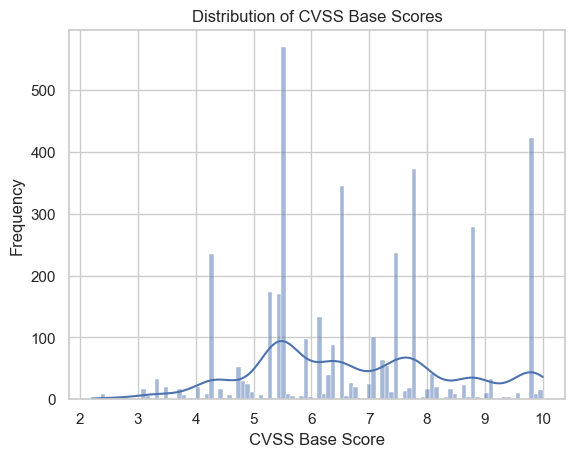

In [18]:
sns.histplot(df['cvss_baseScore'], bins=100, kde=True)
plt.title('Distribution of CVSS Base Scores')
plt.xlabel('CVSS Base Score')
plt.ylabel('Frequency')
plt.show()

The histogram indicates that the vulnerabilities in the dataset range from LOW to CRITICAL CVSS values, with a higher concentration observed in the moderately severe to very severe categories. 

##### Distribution of CVSS Base Scores Based on Attack Vector

The cvss_attackVector field was examined to identify vulnerabilities exploitable over a network, as these are of primary interest. As observed, the majority of vulnerabilities in the dataset are network-exploitable. This information will be used later to guide the selection of relevant CVEs.

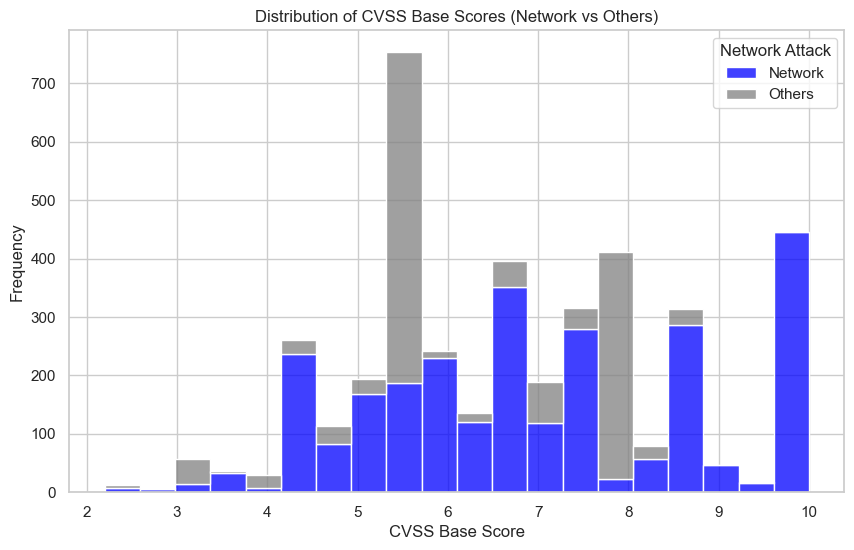

In [19]:
df['isNetwork'] = df['cvss_attackVector'] == 'NETWORK'
df['NOprivilegesRequired'] = df['cvss_privilegesRequired'] == 'NONE'
df['NOprivilegesRequired'] = df['cvss_privilegesRequired'] == 'LOW'

plt.figure(figsize=(10,6))
sns.histplot(data=df, x='cvss_baseScore', bins=20, hue='isNetwork', multiple='stack', palette={True: 'blue', False: 'grey'})
plt.title('Distribution of CVSS Base Scores (Network vs Others)')
plt.xlabel('CVSS Base Score')
plt.ylabel('Frequency')
plt.legend(title='Network Attack', labels=['Network', 'Others'])
plt.show()

It is evident that a large proportion of the vulnerabilities correspond to the Network attack vector.

##### Distribution of CVSS Base Scores Based on Privileges Required

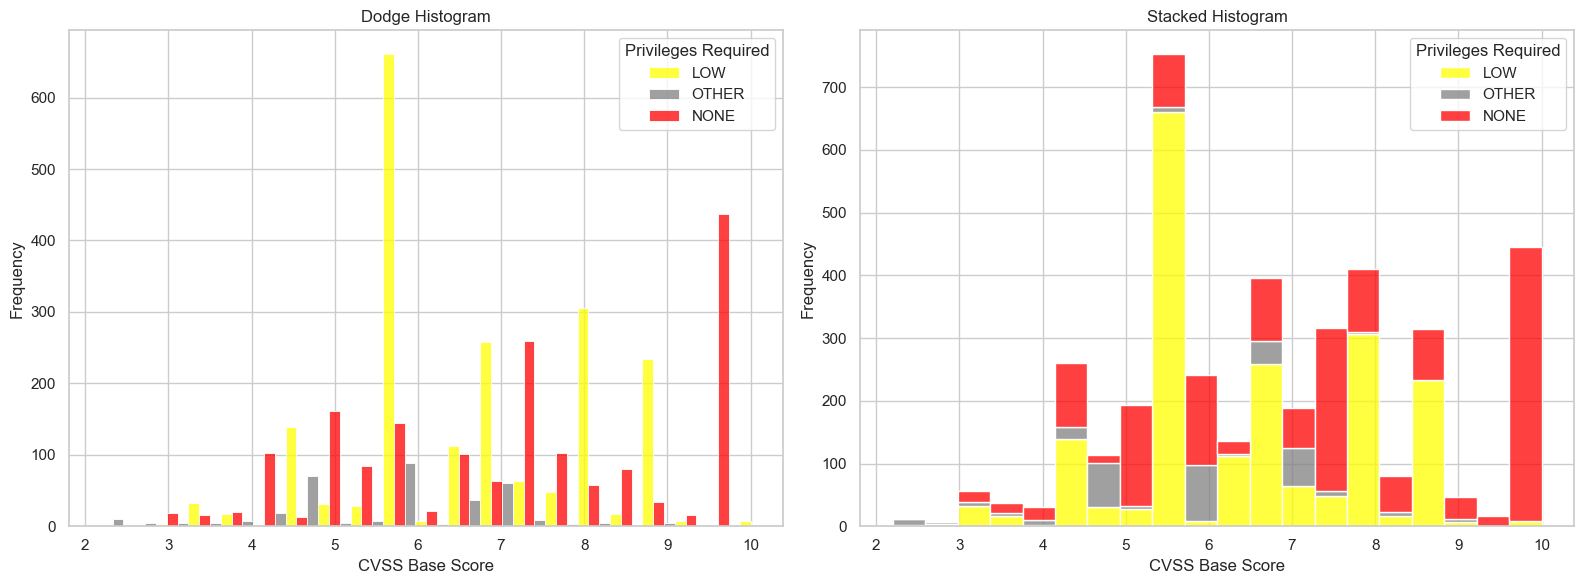

In [20]:
df['privileges_color'] = np.where(df['cvss_privilegesRequired'] == 'NONE', 'NONE',
                                  np.where(df['cvss_privilegesRequired'] == 'LOW', 'LOW', 'OTHER'))

palette = {'NONE': 'red', 'LOW': 'yellow', 'OTHER': 'grey'}

# Create 1 row, 2 columns of plots
fig, axes = plt.subplots(1, 2, figsize=(16,6))

# Left plot: dodge (side-by-side bars)
sns.histplot(data=df, x='cvss_baseScore', bins=20, hue='privileges_color', 
             multiple='dodge', palette=palette, ax=axes[0])
axes[0].set_title('Dodge Histogram')
axes[0].set_xlabel('CVSS Base Score')
axes[0].set_ylabel('Frequency')
axes[0].legend(title='Privileges Required', labels=['LOW', 'OTHER', 'NONE'])

# Right plot: stack (stacked bars)
sns.histplot(data=df, x='cvss_baseScore', bins=20, hue='privileges_color', 
             multiple='stack', palette=palette, ax=axes[1])
axes[1].set_title('Stacked Histogram')
axes[1].set_xlabel('CVSS Base Score')
axes[1].set_ylabel('Frequency')
axes[1].legend(title='Privileges Required', labels=['LOW', 'OTHER', 'NONE'])

plt.tight_layout()
plt.show()

These two graphs present the same data in different formats to provide a clearer view of the distribution. Most vulnerabilities are categorized as requiring LOW or NO privileges. Notably, nearly all critical vulnerabilities require no privileges, whereas the medium-range CVSS base scores are primarily associated with LOW privileges, though a considerable portion also requires no privileges.

##### Distribution of CVSS Base Scores by User Interaction

To better understand the dynamics of the vulnerabilities, the user interaction aspect was analyzed. In the graph, the green color indicates that user interaction is required, which is disadvantageous from an attacker’s perspective, whereas the red color represents vulnerabilities that do not require user interaction, posing a critical risk from a typical user’s point of view.

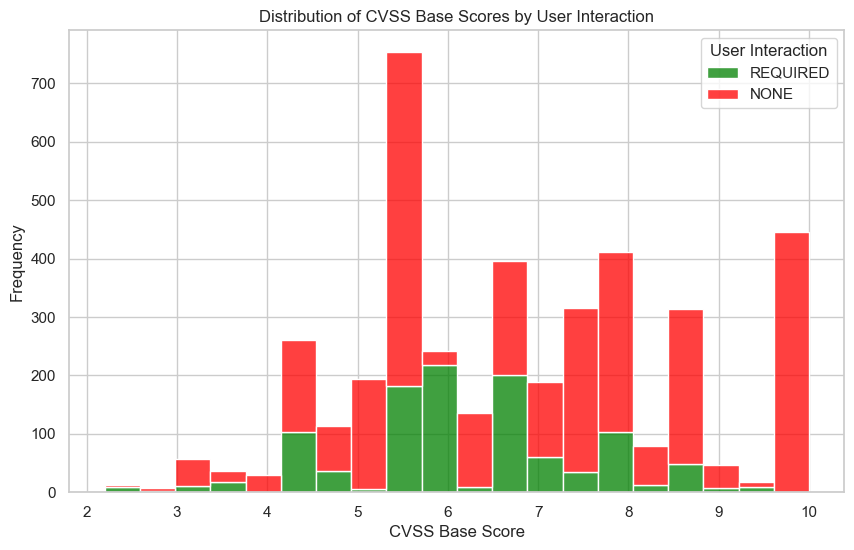

In [21]:
# Step 1: Handle NaN values in userInteraction
df['userInteraction'] = df['cvss_userInteraction'].fillna('UNKNOWN')

# Step 3: Define a color palette including UNKNOWN
palette_ui = {'NONE': 'red', 'REQUIRED': 'green', 'UNKNOWN': 'grey'}

# Step 4: Plot the histogram
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='cvss_baseScore', bins=20, hue='userInteraction', multiple='stack', palette=palette_ui)
plt.title('Distribution of CVSS Base Scores by User Interaction')
plt.xlabel('CVSS Base Score')
plt.ylabel('Frequency')
plt.legend(title='User Interaction', labels=['REQUIRED', 'NONE', 'UNKNOWN'])
plt.show()

In [22]:
df_NOinteraction = df['userInteraction'] == 'NONE'
df_YESinteraction = df['userInteraction'] == 'REQUIRED'
NOinter_num = sum(df_NOinteraction)
nointer_percentage = (NOinter_num/(len(df)-1007))*100
print('Percentage of vulns with interaction NOT required:', nointer_percentage, "%")

Percentage of vulns with interaction NOT required: 90.19312009656005 %


It is evident that most CVSS scores associated with these vulnerabilities do not require user interaction, making exploitation comparatively easier from an attacker’s perspective.

##### Distribution of CVSS Base Scores by Confidentiality, Integrity, and Availability

We now plot a graph which will identify how the violation of Confidentiality, Integrity, and Availability is distributed among the various CVSS scores. 

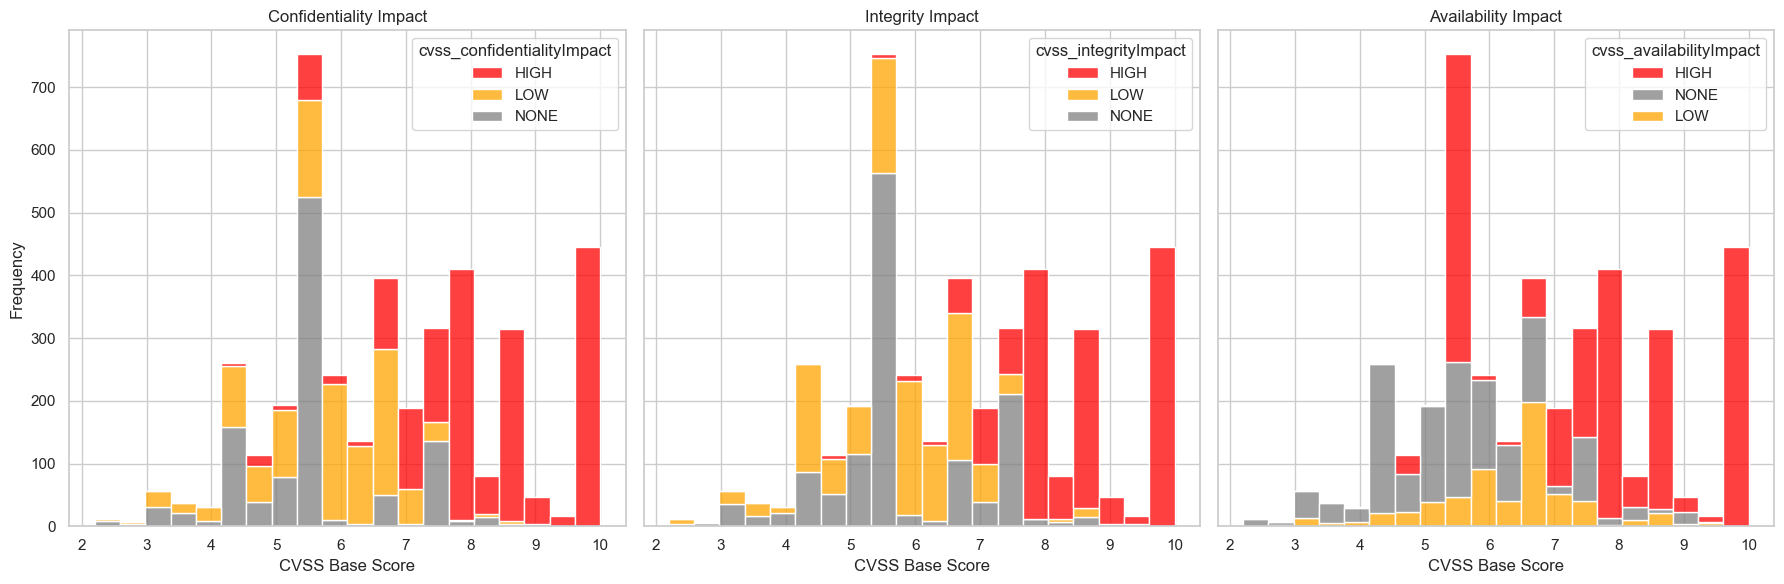

In [23]:
# Create color palette for impact levels
palette_impact = {'NONE': 'grey', 'LOW': 'orange', 'HIGH': 'red'}

# Create subplots: 1 row, 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18,6), sharey=True)

# Confidentiality
sns.histplot(
    data=df, x='cvss_baseScore', bins=20, hue='cvss_confidentialityImpact',
    multiple='stack', palette=palette_impact, ax=axes[0]
)
axes[0].set_title('Confidentiality Impact')
axes[0].set_xlabel('CVSS Base Score')
axes[0].set_ylabel('Frequency')

# Integrity
sns.histplot(
    data=df, x='cvss_baseScore', bins=20, hue='cvss_integrityImpact',
    multiple='stack', palette=palette_impact, ax=axes[1]
)
axes[1].set_title('Integrity Impact')
axes[1].set_xlabel('CVSS Base Score')
axes[1].set_ylabel('')

# Availability
sns.histplot(
    data=df, x='cvss_baseScore', bins=20, hue='cvss_availabilityImpact',
    multiple='stack', palette=palette_impact, ax=axes[2]
)
axes[2].set_title('Availability Impact')
axes[2].set_xlabel('CVSS Base Score')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()

As can be seen, in the higher range of the CVSS base scores, there is a noticeable increase in the presence of HIGH impact across all components of the CIA triad, which is consistent with expectations.

##### Distribution of CVSS Base Scores by Vulnerability Scope

The Scope metric indicates whether a vulnerability in one component can impact another component in a different security scope, making it a critical factor in assessing the overall severity of a vulnerability.

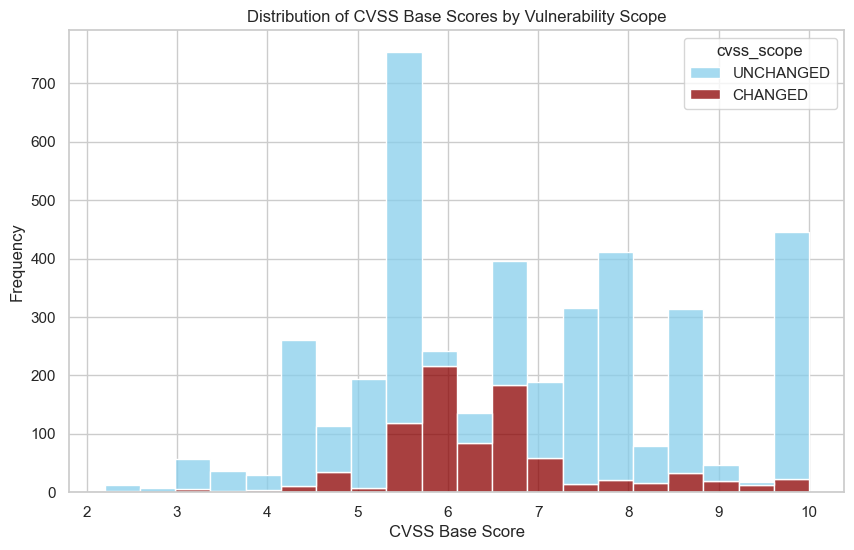

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Drop NaN values in cvss_scope or cvss_baseScore
df_scope = df[df['cvss_scope'].notna() & df['cvss_baseScore'].notna()]

# Define colors for each scope type
palette_scope = {'UNCHANGED': 'skyblue', 'CHANGED': 'darkred'}

# Plot histogram
plt.figure(figsize=(10,6))
sns.histplot(
    data=df_scope,
    x='cvss_baseScore',
    bins=20,
    hue='cvss_scope',
    multiple='stack',
    palette=palette_scope
)

plt.title('Distribution of CVSS Base Scores by Vulnerability Scope')
plt.xlabel('CVSS Base Score')
plt.ylabel('Frequency')

plt.show()


#### 3. Report descriptive statistics of EPSS and/or show its distribution

In [25]:
df[['epss', 'percentile']].describe()


,epss,percentile
count,4321.000000,4321.000000
mean,0.001477,0.130904
std,0.017287,0.151286
min,0.000020,0.000200
25%,0.000240,0.050540
50%,0.000320,0.081450
75%,0.000470,0.142320
max,0.810640,0.991250


- The majority of vulnerabilities have low EPSS
- Percentiles show how each EPSS ranks among all vulnerabilities

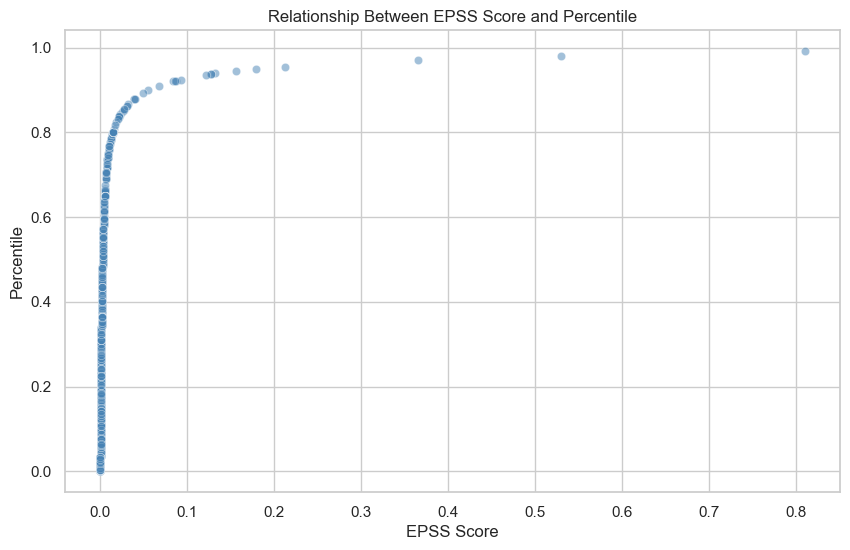

In [26]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df,
    x='epss',
    y='percentile',
    alpha=0.5,        # transparency (helps when you have many points)
    color='steelblue'
)
plt.title('Relationship Between EPSS Score and Percentile')
plt.xlabel('EPSS Score')
plt.ylabel('Percentile')
#plt.xscale("log")
#plt.yscale("log")
plt.show()


as can be seen, once a vulnerability has an EPSS score of roughly 0.1 (10% chance of exploitation), it is already "worse" than 90% of all other vulnerabilities.

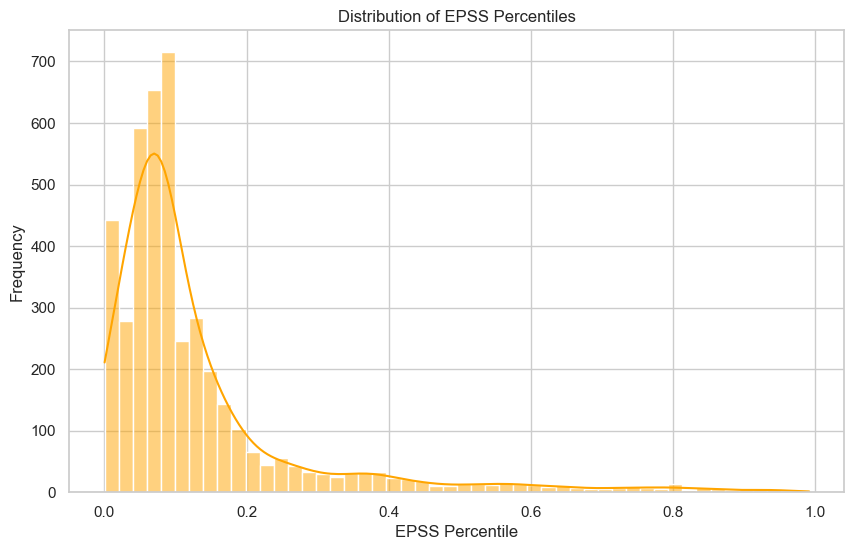

In [27]:
plt.figure(figsize=(10,6))
sns.histplot(df['percentile'], bins=50, kde=True, color='orange')
plt.title('Distribution of EPSS Percentiles')
plt.xlabel('EPSS Percentile')
plt.ylabel('Frequency')
plt.show()

The vast majority of vulnerabilities fall into the lower percentiles ($0.0$ to $0.2$). This suggests that most identified vulnerabilities have a very low probability of exploitation. Note the frequency drops significantly as percentiles increase.

#### 4. Produce a scatter plot showing CVSS vs EPSS

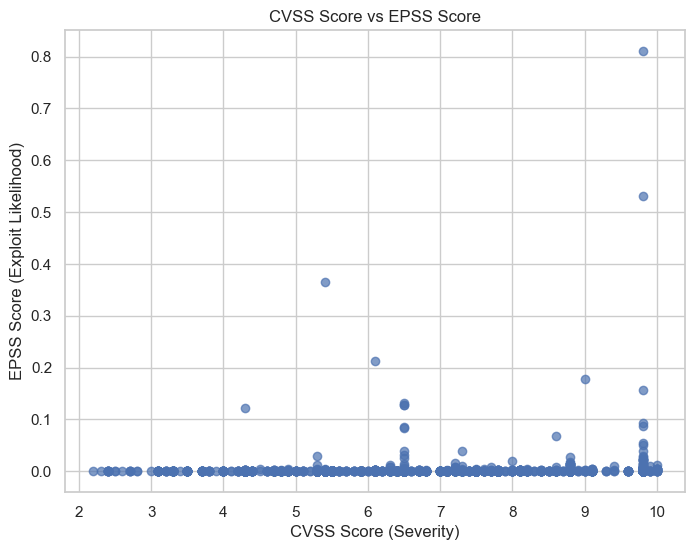

In [28]:
# Basic scatter plot: CVSS vs EPSS
plt.figure(figsize=(8,6))
plt.scatter(df["cvss_baseScore"], df["epss"], alpha=0.7)

plt.title("CVSS Score vs EPSS Score")
plt.xlabel("CVSS Score (Severity)")
plt.ylabel("EPSS Score (Exploit Likelihood)")
#plt.xscale("log")
#plt.yscale("log")
plt.grid(True)
plt.show()

There is a cluster of vulnerabilities with high CVSS scores (9.0–10.0) that have near-zero EPSS scores. This visually confirms that a high severity rating does not automatically indicate a high probability of exploitation.

Secondly, only a small fraction of vulnerabilities appear in the upper-right quadrant (High CVSS + High EPSS). These represent the true critical vulnerabilities, that are both severe and actively being targeted.

# CVE Selection

The initial step of this approach involves selecting only the relevant columns from the dataset and discarding those that are not useful to the analysis. From the refined dataset, a total of ten CVEs are selected for further evaluation.

Rather than focusing exclusively on the most severe vulnerabilities, this methodology acknowledges that real-world attackers do not always prioritize vulnerabilities with the highest severity scores. Furthermore, the availability of artificial intelligence systems, capable of processing large volumes of data, enables a more diversified selection strategy. For these reasons, the “1–3–6 technique” is adopted.

This means that one CVE is selected at random, preferably from the mid-to-lower severity range. This random selection accounts for the inherent unpredictability of real-world exploitation scenarios and helps capture edge cases that may otherwise be overlooked. Next, three CVEs are selected through the use of a large language model (ChatGPT), which is prompt-engineered to leverage its contextual knowledge and identify vulnerabilities it estimates to have a high likelihood of exploitation. The remaining six CVEs are chosen based on a manual analysis which involves data manipulation and visualization, followed by a detailed review of vulnerability descriptions to identify the most suitable candidates.

By combining probabilistic selection, computational power, and human judgment, this approach integrates multiple analytical perspectives. As a result, it aims to provide broader coverage of potential exploitation scenarios and produce more balanced and robust results.

<small>*It is important to note that the random selection of one CVE could be a critical factor in this methodology. Given the inherently unpredictable nature of cybersecurity threats, incorporating randomness into the selection process is expected to yield more advantages than disadvantages over time, particularly in long-term analyses.*</small>

##### Preliminary Selection Framework

To select an appropriate set of CVEs for analysis, a multi-stage filtering and prioritization process is applied.

- First, CVEs with a CVSS base score greater than 6 are considered, with a preference for those in the 6.2–8.0 range. Vulnerabilities with extremely high CVSS scores are often prioritized by vendors and patch management teams, making them less attractive targets for sustained exploitation. Conversely, vulnerabilities in the mid-to-high severity range may present a more realistic exploitation window, as attackers may anticipate slower remediation efforts compared to critical vulnerabilities.

- Second, CVEs whose Attack Vector is not classified as NETWORK are excluded. Vulnerabilities requiring local, physical, or adjacent network access generally impose additional constraints on attackers, as they require proximity to the target system. Network-based vulnerabilities, on the other hand, are more attractive due to their remote exploitability.

- Next, priority is given to vulnerabilities that do not require prior privileges. CVEs that can be exploited without authenticated or elevated access significantly lower the barrier to exploitation and are therefore more appealing to adversaries.

- From this already restricted subset, CVEs that require user interaction are excluded. Vulnerabilities that can be exploited without user involvement are typically easier to weaponize and automate, increasing their likelihood of real-world exploitation.

- Subsequently, emphasis is placed on CVEs that have a HIGH impact rating in at least one component of the CIA triad (Confidentiality, Integrity, or Availability). Vulnerabilities with a high impact on these dimensions are more likely to yield meaningful outcomes for attackers, such as data exfiltration, system compromise, or service disruption.

- In addition, vulnerabilities with a CHANGED scope are prioritized. A changed scope indicates that successful exploitation allows attackers to impact resources beyond the original authorization boundaries of the vulnerable component, making such CVEs particularly attractive from an adversarial perspective.

##### Filter the CVEs with low EPSS (<1%) [*REQUIREMENT*]

In [29]:
MYdf_filtered = MYdf[MYdf['epss'] <= 0.01]

In [30]:
# MYdf_filtered

##### Implementation of the Preliminary Selection Framework

In [51]:
# 1. Filter CVEs with CVSS score > 6, preferably in the 6.2 - 8 range
filtered_df = MYdf_filtered[(MYdf_filtered['cvss_baseScore'] > 6) & (MYdf_filtered['cvss_baseScore'] <= 8)]

# 2. Keep only NETWORK attack vector
filtered_df = filtered_df[filtered_df['cvss_attackVector'] == 'NETWORK']

# 3. Prioritize CVEs that do NOT require privileges
filtered_df = filtered_df[filtered_df['cvss_privilegesRequired'] == 'NONE']

# 4. Exclude CVEs that require user interaction
filtered_df = filtered_df[filtered_df['cvss_userInteraction'] == 'NONE']

# 5. Keep CVEs where any CIA impact is HIGH
cia_columns = ['cvss_confidentialityImpact', 'cvss_integrityImpact', 'cvss_availabilityImpact']
filtered_df = filtered_df[filtered_df[cia_columns].isin(['HIGH']).any(axis=1)]

# 6. Prioritize CVEs with Vulnerability Scope = CHANGED
filtered_df = filtered_df[filtered_df['cvss_scope'] == 'CHANGED']

# 7. Select CVEs with highest EPSS scores (or optionally exclude already extremely high EPSS if desired)
# Here we can sort by EPSS descending
final_df = filtered_df.sort_values(by='epss', ascending=False)

# 8. Select CVEs with attackComplexity == LOW
final_df = filtered_df[filtered_df['cvss_attackComplexity'] == 'LOW']


final_df




,cve.id,cve.sourceIdentifier,num_references,description,cwe_list,cvss_baseScore,cvss_baseSeverity,cvss_attackVector,cvss_attackComplexity,cvss_privilegesRequired,cvss_userInteraction,cvss_confidentialityImpact,cvss_integrityImpact,cvss_availabilityImpact,cvss_scope,epss,percentile


As this initial application of the filtering methodology did not yield any results, it became necessary to relax certain selection constraints. Specifically, the sixth criterion was removed, allowing CVEs with a Vulnerability Scope value of both CHANGED and UNCHANGED to be considered.

This criterion was selected for relaxation because vulnerabilities with an UNCHANGED scope may still present a high likelihood of exploitation. Although such vulnerabilities do not allow attackers to affect resources beyond the authorization boundaries of the vulnerable component, they can nonetheless remain highly attractive targets, particularly when combined with favorable exploitability characteristics such as low attack complexity and the absence of required privileges.

In [52]:
# 1. Filter CVEs with CVSS score > 6, preferably in the 6 - 8 range
filtered_df = MYdf_filtered[(MYdf_filtered['cvss_baseScore'] > 6) & (MYdf_filtered['cvss_baseScore'] <= 8)]

# 2. Keep only NETWORK attack vector
filtered_df = filtered_df[filtered_df['cvss_attackVector'] == 'NETWORK']

# 3. Prioritize CVEs that do NOT require privileges
filtered_df = filtered_df[filtered_df['cvss_privilegesRequired'] == 'NONE']

# 4. Exclude CVEs that require user interaction
filtered_df = filtered_df[filtered_df['cvss_userInteraction'] == 'NONE']

# 5. Keep CVEs where any CIA impact is HIGH
cia_columns = ['cvss_confidentialityImpact', 'cvss_integrityImpact', 'cvss_availabilityImpact']
filtered_df = filtered_df[filtered_df[cia_columns].isin(['HIGH']).any(axis=1)]

# 6. Prioritize CVEs with Vulnerability Scope = CHANGED
#filtered_df = filtered_df[filtered_df['cvss_scope'] == 'CHANGED']

# 7. Select CVEs with highest EPSS scores (or optionally exclude already extremely high EPSS if desired)
# Here we can sort by EPSS descending
final_df = filtered_df.sort_values(by='epss', ascending=False)

# 8. Select CVEs with attackComplexity == LOW
final_df = filtered_df[filtered_df['cvss_attackComplexity'] == 'LOW']


print(final_df["cvss_baseScore"].describe())


count    214.0
mean       7.5
std        0.0
min        7.5
25%        7.5
50%        7.5
75%        7.5
max        7.5
Name: cvss_baseScore, dtype: float64


This produces 189 results. Out of which we will narrow it down to 6 candidates.

##### Removing CVEs which have already been neutralised or patched.

In [33]:
import re

# Extended regex pattern for patch-related phrases (non-capturing groups)
exclude_pattern = (
    r'(?:'
    r'\bpatched\b|'
    r'\bpatch(?:ed|es|ing)?\s+(?:in|since|on)\b|'
    r'\bfixed\b|'
    r'\bfix(?:ed|es|ing)?\s+(?:in|since|on)\b|'
    r'\bresolved\b|'
    r'\bresolve(?:d|s|ing)?\s+(?:in|since|on)\b|'
    r'\baddress(?:ed|es|ing)?\b|'
    r'\bmitigated\b|'
    r'\bmitigate(?:d|s|ing)?\s+(?:in|since|on)\b|'
    r'\bremediated\b|'
    r'\bremediate(?:d|s|ing)?\s+(?:in|since|on)\b'
    r')'
)

# Exclude CVEs mentioning patch/fix/remediation terms
filtered_final_df = final_df[
    ~final_df['description'].str.contains(exclude_pattern, case=False, na=False, regex=True)
].sort_values(by='epss', ascending=False)

filtered_final_df


,cve.id,cve.sourceIdentifier,num_references,description,cwe_list,cvss_baseScore,cvss_baseSeverity,cvss_attackVector,cvss_attackComplexity,cvss_privilegesRequired,cvss_userInteraction,cvss_confidentialityImpact,cvss_integrityImpact,cvss_availabilityImpact,cvss_scope,epss,percentile
3543,CVE-2025-52905,psirt@paloaltonetworks.com,2,Improper Input Validation vulnerability in TOT...,[CWE-20],7.5,HIGH,NETWORK,LOW,NONE,NONE,NONE,NONE,HIGH,UNCHANGED,0.00375,0.58523
18,CVE-2025-20703,security@mediatek.com,1,"In Modem, there is a possible out of bounds re...",[CWE-125],7.5,HIGH,NETWORK,LOW,NONE,NONE,NONE,NONE,HIGH,UNCHANGED,0.00278,0.51085
3582,CVE-2025-48392,security@apache.org,2,A vulnerability in Apache IoTDB.\n\nThis issue...,"[CWE-400, CWE-400]",7.5,HIGH,NETWORK,LOW,NONE,NONE,NONE,NONE,HIGH,UNCHANGED,0.00241,0.47481
2444,CVE-2025-34183,disclosure@vulncheck.com,5,Ilevia EVE X1 Server version ≤ 4.7.18.0.eden c...,[CWE-532],7.5,HIGH,NETWORK,LOW,NONE,NONE,HIGH,NONE,NONE,UNCHANGED,0.00239,0.47147
2446,CVE-2025-34185,disclosure@vulncheck.com,5,Ilevia EVE X1 Server version ≤ 4.7.18.0.eden c...,"[CWE-22, CWE-200, CWE-22]",7.5,HIGH,NETWORK,LOW,NONE,NONE,HIGH,NONE,NONE,UNCHANGED,0.00234,0.46353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,CVE-2025-33102,psirt@us.ibm.com,1,IBM Concert Software 1.0.0 through 1.1.0 uses ...,[CWE-327],7.5,HIGH,NETWORK,LOW,NONE,NONE,HIGH,NONE,NONE,UNCHANGED,0.00016,0.02647
11,CVE-2025-7731,Mitsubishielectric.Psirt@yd.MitsubishiElectric...,3,Cleartext Transmission of Sensitive Informatio...,[CWE-319],7.5,HIGH,NETWORK,LOW,NONE,NONE,HIGH,NONE,NONE,UNCHANGED,0.00016,0.02464
1520,CVE-2024-45671,psirt@us.ibm.com,1,"IBM Security Verify Information Queue 10.0.5, ...",[CWE-327],7.5,HIGH,NETWORK,LOW,NONE,NONE,HIGH,NONE,NONE,UNCHANGED,0.00016,0.02647
3121,CVE-2025-57440,cve@mitre.org,2,The Blackmagic ATEM Mini Pro 2.7 exposes an un...,[CWE-400],7.5,HIGH,NETWORK,LOW,NONE,NONE,NONE,NONE,HIGH,UNCHANGED,0.00014,0.01748


The current filtering process has removed 27 CVEs from the initial selection. The next steps involve applying additional criteria, with the aim of further narrowing the candidate set to a manageable number suitable for detailed manual inspection and analysis.

##### Take into consideration those CVEs which have more than one impact set to a different value than "NONE"

In [34]:
#filtered_final_df

From the remaining 162 CVEs, we further refine the selection by focusing on vulnerabilities that have high impact in multiple dimensions of the CIA triad. Specifically, we retain only those CVEs for which at least two out of the three impact metrics — Confidentiality, Integrity, and Availability — are rated as HIGH.

This approach ensures that the selected vulnerabilities are not only exploitable but also capable of causing significant damage in multiple areas, making them more relevant from an adversarial perspective.

In [53]:
# Define the point system and the columns to apply it to
score_map = {'HIGH': 2, 'MEDIUM': 1, 'LOW': 0.5, 'NONE': 0}
cia_columns = ['cvss_confidentialityImpact', 'cvss_integrityImpact', 'cvss_availabilityImpact']

# Calculate the score for each row
filtered_final_df['score'] = filtered_final_df[cia_columns].apply(lambda row: sum(score_map.get(val, 0) for val in row), axis=1)

# Keep rows with score >= 2.5
filtered_final_df2 = filtered_final_df[filtered_final_df['score'] >= 2.5]

In [36]:
filtered_final_df2

,cve.id,cve.sourceIdentifier,num_references,description,cwe_list,cvss_baseScore,cvss_baseSeverity,cvss_attackVector,cvss_attackComplexity,cvss_privilegesRequired,cvss_userInteraction,cvss_confidentialityImpact,cvss_integrityImpact,cvss_availabilityImpact,cvss_scope,epss,percentile,score


As no CVEs met the criterion of having high impact in at least two CIA triad dimensions, the selection process now proceeds to visual exploration of the dataset. This step is intended to provide additional insights and guide further narrowing of the candidate set. By visualizing key metrics and patterns within the data, we aim to identify meaningful trends that can inform more targeted filtering decisions, ultimately leading to a manageable number of CVEs for detailed manual analysis.

##### Data visualisation for inducing more filtering ideas


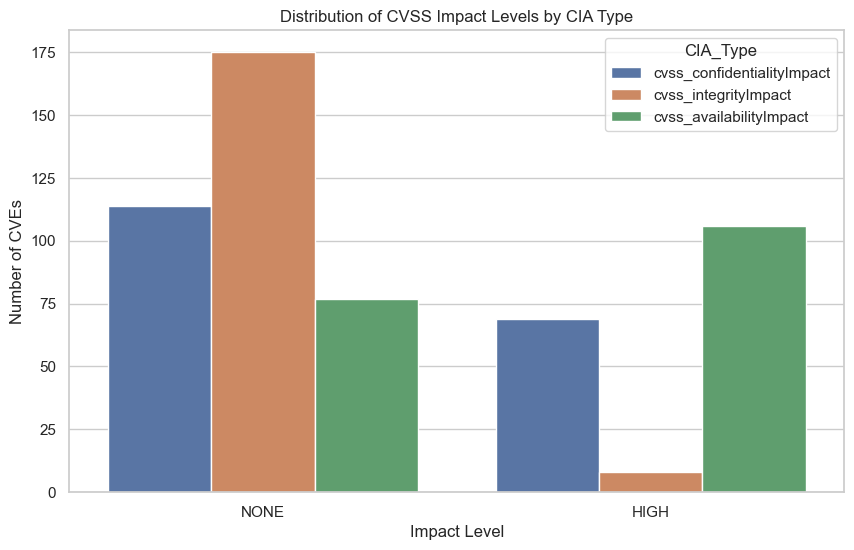

In [54]:
# Example: columns
cia_columns = ['cvss_confidentialityImpact', 'cvss_integrityImpact', 'cvss_availabilityImpact']

# Melt the DataFrame so that all CIA columns are in one column
melted_df = filtered_final_df.melt(value_vars=cia_columns, 
                                   var_name='CIA_Type', 
                                   value_name='Impact_Level')

# Plot a histogram (countplot) for each CIA type
plt.figure(figsize=(10,6))
sns.countplot(data=melted_df, x='Impact_Level', hue='CIA_Type')
plt.title('Distribution of CVSS Impact Levels by CIA Type')
plt.xlabel('Impact Level')
plt.ylabel('Number of CVEs')
plt.show()


Analysis of the selected CVEs shows that almost none exhibit a high Integrity impact. Approximately 60 CVEs have a high Confidentiality impact, while the majority display a high Availability impact.

It is important to consider these results in the context of attacker motivations. The likelihood of an attacker exploiting a vulnerability purely to cause a denial-of-service is generally lower than that of attackers seeking to compromise Confidentiality or Integrity. Vulnerabilities that grant access to sensitive data (high Confidentiality impact) are typically the most attractive to financially motivated actors, whereas high Integrity impact is often pursued by state level attackers with goals related to espionage or sabotage. High Availability impact, on the other hand, tends to appeal to attackers interested in service disruption or gaining rapid notoriety.

These observations suggest that, for practical prioritization, CVEs with high Confidentiality impact may be of greatest interest, though Availability-impacting vulnerabilities should still be considered for a comprehensive threat assessment.

##### Keeping CVEs mentioning high-value targets

The next step in the selection process focuses on high-value targets. CVEs that do not reference critical assets or systems are discarded, as vulnerabilities affecting these targets are generally more attractive to attackers due to their potential impact. By retaining only CVEs associated with critical components, the candidate set is further refined to prioritize vulnerabilities that are likely to be of greatest interest to adversaries.

In [38]:
# 1. Define inclusion keywords — expand as needed
include_keywords = [
    "router", "server", "microsoft", "android", "linux", "vpn", "firewall",
    "firmware", "camera", "iot", "database", "windows", "apache", "nginx",
    "switch", "mail", "exchange", "cisco", "juniper", "d-link", "printer"
]

# 2. Combine into a single regex pattern (case-insensitive)
include_pattern = r'(' + '|'.join(include_keywords) + r')'

# 3. Filter the DataFrame to keep only matching descriptions
target_filtered_df = filtered_final_df[
    filtered_final_df['description'].str.contains(include_pattern, case=False, na=False, regex=True)
].sort_values(by='epss', ascending=False)

# 4. View the filtered subset
#print(len(target_filtered_df))

C:\Temp\ipykernel_13184\3738886715.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered_final_df['description'].str.contains(include_pattern, case=False, na=False, regex=True)


In [39]:
target_filtered_df

,cve.id,cve.sourceIdentifier,num_references,description,cwe_list,cvss_baseScore,cvss_baseSeverity,cvss_attackVector,cvss_attackComplexity,cvss_privilegesRequired,cvss_userInteraction,cvss_confidentialityImpact,cvss_integrityImpact,cvss_availabilityImpact,cvss_scope,epss,percentile,score
3582,CVE-2025-48392,security@apache.org,2,A vulnerability in Apache IoTDB.\n\nThis issue...,"[CWE-400, CWE-400]",7.5,HIGH,NETWORK,LOW,NONE,NONE,NONE,NONE,HIGH,UNCHANGED,0.00241,0.47481,2
2444,CVE-2025-34183,disclosure@vulncheck.com,5,Ilevia EVE X1 Server version ≤ 4.7.18.0.eden c...,[CWE-532],7.5,HIGH,NETWORK,LOW,NONE,NONE,HIGH,NONE,NONE,UNCHANGED,0.00239,0.47147,2
2446,CVE-2025-34185,disclosure@vulncheck.com,5,Ilevia EVE X1 Server version ≤ 4.7.18.0.eden c...,"[CWE-22, CWE-200, CWE-22]",7.5,HIGH,NETWORK,LOW,NONE,NONE,HIGH,NONE,NONE,UNCHANGED,0.00234,0.46353,2
126,CVE-2025-9784,secalert@redhat.com,11,A flaw was found in Undertow where malformed c...,"[CWE-770, CWE-404]",7.5,HIGH,NETWORK,LOW,NONE,NONE,NONE,NONE,HIGH,UNCHANGED,0.00200,0.42515,2
1470,CVE-2025-10225,15ede60e-6fda-426e-be9c-e788f151a377,1,Improper Restriction of Operations within the ...,[CWE-119],7.5,HIGH,NETWORK,LOW,NONE,NONE,NONE,NONE,HIGH,UNCHANGED,0.00139,0.34798,2
902,CVE-2025-10060,cna@mongodb.com,1,MongoDB Server may allow upsert operations ret...,[CWE-672],7.5,HIGH,NETWORK,LOW,NONE,NONE,NONE,NONE,HIGH,UNCHANGED,0.00130,0.33441,2
110,CVE-2025-52544,dd59f033-460c-4b88-a075-d4d3fedb6191,1,E3 Site Supervisor Control (firmware version <...,[CWE-20],7.5,HIGH,NETWORK,LOW,NONE,NONE,HIGH,NONE,NONE,UNCHANGED,0.00122,0.32228,2
1477,CVE-2025-56406,cve@mitre.org,3,An issue was discovered in mcp-neo4j 0.3.0 all...,"[CWE-77, CWE-200, CWE-284]",7.5,HIGH,NETWORK,LOW,NONE,NONE,HIGH,NONE,NONE,UNCHANGED,0.00108,0.29912,2
113,CVE-2025-52547,dd59f033-460c-4b88-a075-d4d3fedb6191,1,E3 Site Supervisor Control (firmware version <...,[CWE-20],7.5,HIGH,NETWORK,LOW,NONE,NONE,NONE,NONE,HIGH,UNCHANGED,0.00100,0.28487,2
1218,CVE-2025-53805,secure@microsoft.com,1,Out-of-bounds read in Windows Internet Informa...,[CWE-125],7.5,HIGH,NETWORK,LOW,NONE,NONE,NONE,NONE,HIGH,UNCHANGED,0.00095,0.27607,2


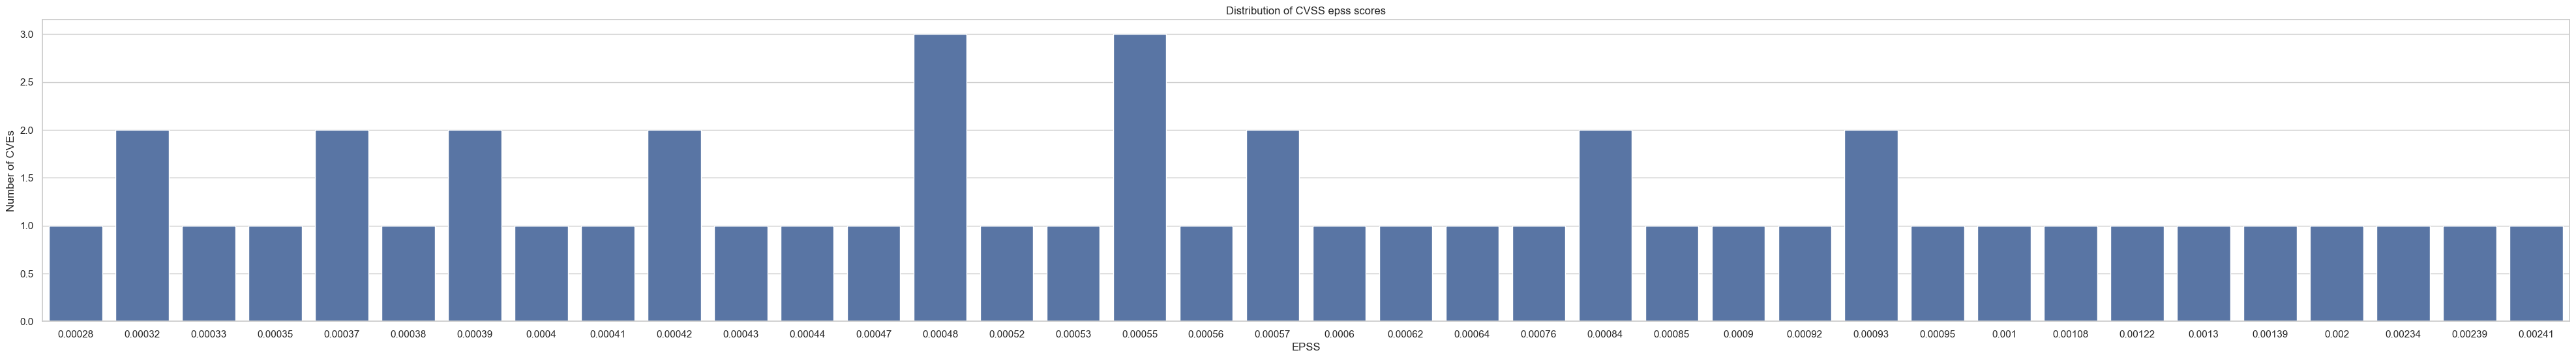

In [40]:
# Plot distribution of EPSS scores to get the general idea
plt.figure(figsize=(50,6))
sns.countplot(data=target_filtered_df, x='epss')
plt.title('Distribution of CVSS epss scores')
plt.xlabel('EPSS')
plt.ylabel('Number of CVEs')
#plt.xscale("log")
plt.show()

##### Filter by critical CWEs

The selection is further refined by focusing on specific Common Weakness Enumerations (CWEs) that are commonly associated with impactful exploitation techniques. CVEs linked to CWEs that attackers are more likely to leverage in real-world scenarios are prioritized, as these weaknesses often enable reliable exploitation paths and meaningful post-exploitation outcomes.

This step ensures that the remaining CVEs align more closely with attacker capabilities and objectives, thereby improving the relevance of the final candidate set.

In [41]:
# Define critical CWEs that attackers often target
critical_cwes = [
    "CWE-79",   # Cross-Site Scripting (XSS)
    "CWE-89",   # SQL Injection
    "CWE-119",  # Memory Buffer Overflow
    "CWE-120",  # Classic Buffer Overflow
    "CWE-20",   # Improper Input Validation
    "CWE-352",  # CSRF
    "CWE-787",  # Out-of-bounds Write
    "CWE-78",   # OS Command Injection
    "CWE-94",   # Code Injection
    "CWE-416",  # Use-After-Free
    "CWE-476",  # NULL Pointer Dereference
    "CWE-362",  # Race Condition
    "CWE-22",   # Path Traversal
    "CWE-264",  # Permissions, Privileges, Access Control
    "CWE-287",  # Authentication Issues
    "CWE-200",  # Information Exposure
    "CWE-269",  # Privilege Escalation
]

# Create a regex pattern to match any critical CWE
cwe_pattern = r'(?:' + '|'.join(critical_cwes) + r')'

# Add a new column indicating whether each CVE is critical based on CWE
target_filtered_df['is_critical_cwe'] = target_filtered_df['cwe_list'].astype(str).str.contains(
    cwe_pattern, case=False, na=False, regex=True
)

# Sort first by critical CWEs (True first), then by EPSS descending
priority_df = target_filtered_df.sort_values(
    by=['is_critical_cwe', 'epss'], ascending=[False, False]
)

# View the prioritized CVEs

priority_df#[['cve.id', 'cwe_list', 'epss', 'is_critical_cwe', 'description']]



,cve.id,cve.sourceIdentifier,num_references,description,cwe_list,cvss_baseScore,cvss_baseSeverity,cvss_attackVector,cvss_attackComplexity,cvss_privilegesRequired,cvss_userInteraction,cvss_confidentialityImpact,cvss_integrityImpact,cvss_availabilityImpact,cvss_scope,epss,percentile,score,is_critical_cwe
2446,CVE-2025-34185,disclosure@vulncheck.com,5,Ilevia EVE X1 Server version ≤ 4.7.18.0.eden c...,"[CWE-22, CWE-200, CWE-22]",7.5,HIGH,NETWORK,LOW,NONE,NONE,HIGH,NONE,NONE,UNCHANGED,0.00234,0.46353,2,True
1470,CVE-2025-10225,15ede60e-6fda-426e-be9c-e788f151a377,1,Improper Restriction of Operations within the ...,[CWE-119],7.5,HIGH,NETWORK,LOW,NONE,NONE,NONE,NONE,HIGH,UNCHANGED,0.00139,0.34798,2,True
110,CVE-2025-52544,dd59f033-460c-4b88-a075-d4d3fedb6191,1,E3 Site Supervisor Control (firmware version <...,[CWE-20],7.5,HIGH,NETWORK,LOW,NONE,NONE,HIGH,NONE,NONE,UNCHANGED,0.00122,0.32228,2,True
1477,CVE-2025-56406,cve@mitre.org,3,An issue was discovered in mcp-neo4j 0.3.0 all...,"[CWE-77, CWE-200, CWE-284]",7.5,HIGH,NETWORK,LOW,NONE,NONE,HIGH,NONE,NONE,UNCHANGED,0.00108,0.29912,2,True
113,CVE-2025-52547,dd59f033-460c-4b88-a075-d4d3fedb6191,1,E3 Site Supervisor Control (firmware version <...,[CWE-20],7.5,HIGH,NETWORK,LOW,NONE,NONE,NONE,NONE,HIGH,UNCHANGED,0.00100,0.28487,2,True
2485,CVE-2025-10042,security@wordfence.com,4,The Quiz Maker plugin for WordPress is vulnera...,[CWE-89],7.5,HIGH,NETWORK,LOW,NONE,NONE,HIGH,NONE,NONE,UNCHANGED,0.00093,0.27309,2,True
2679,CVE-2025-23336,psirt@nvidia.com,1,NVIDIA Triton Inference Server for Windows and...,[CWE-20],7.5,HIGH,NETWORK,LOW,NONE,NONE,NONE,NONE,HIGH,UNCHANGED,0.00093,0.27235,2,True
1291,CVE-2025-55243,secure@microsoft.com,1,Exposure of sensitive information to an unauth...,[CWE-200],7.5,HIGH,NETWORK,LOW,NONE,NONE,HIGH,NONE,NONE,UNCHANGED,0.00085,0.25874,2,True
1691,CVE-2025-9807,security@wordfence.com,2,The The Events Calendar plugin for WordPress i...,[CWE-89],7.5,HIGH,NETWORK,LOW,NONE,NONE,HIGH,NONE,NONE,UNCHANGED,0.00084,0.25694,2,True
1563,CVE-2025-9073,security@wordfence.com,2,The All in one Minifier plugin for WordPress i...,[CWE-89],7.5,HIGH,NETWORK,LOW,NONE,NONE,HIGH,NONE,NONE,UNCHANGED,0.00084,0.25694,2,True


This brings our total CVE count to 19 which is managable for manual review. Note that the Critical ones have the is_critical_cwe column set to TRUE.

In [42]:
#show only CVEs with is_critical_cwe column set to TRUE
critical_only_df = priority_df[priority_df['is_critical_cwe'] == True]
critical_only_df
# Show key columns for clarity
critical_only_df[['cve.id', 'cwe_list', 'epss', 'description']]


,cve.id,cwe_list,epss,description
2446,CVE-2025-34185,"[CWE-22, CWE-200, CWE-22]",0.00234,Ilevia EVE X1 Server version ≤ 4.7.18.0.eden c...
1470,CVE-2025-10225,[CWE-119],0.00139,Improper Restriction of Operations within the ...
110,CVE-2025-52544,[CWE-20],0.00122,E3 Site Supervisor Control (firmware version <...
1477,CVE-2025-56406,"[CWE-77, CWE-200, CWE-284]",0.00108,An issue was discovered in mcp-neo4j 0.3.0 all...
113,CVE-2025-52547,[CWE-20],0.00100,E3 Site Supervisor Control (firmware version <...
2485,CVE-2025-10042,[CWE-89],0.00093,The Quiz Maker plugin for WordPress is vulnera...
2679,CVE-2025-23336,[CWE-20],0.00093,NVIDIA Triton Inference Server for Windows and...
1291,CVE-2025-55243,[CWE-200],0.00085,Exposure of sensitive information to an unauth...
1691,CVE-2025-9807,[CWE-89],0.00084,The The Events Calendar plugin for WordPress i...
1563,CVE-2025-9073,[CWE-89],0.00084,The All in one Minifier plugin for WordPress i...


##### Manual Inspection of CVEs with critical CWE

In [43]:
#Print descriptions to manually inspect
for idx, x in enumerate(critical_only_df.sort_values('epss', ascending=False)[:20].iterrows()):
    print('-'*100)
    print(x[1]['cve.id'], x[1]['epss'], x[1]['cvss_confidentialityImpact'], x[1]['cvss_integrityImpact'], x[1]['cvss_availabilityImpact'])
    print(x[1].description)


----------------------------------------------------------------------------------------------------
CVE-2025-34185 0.00234 HIGH NONE NONE
Ilevia EVE X1 Server version ≤ 4.7.18.0.eden contains a pre-authentication file disclosure vulnerability via the 'db_log' POST parameter. Remote attackers can retrieve arbitrary files from the server, exposing sensitive system information and credentials.
----------------------------------------------------------------------------------------------------
CVE-2025-10225 0.00139 NONE NONE HIGH
Improper Restriction of Operations within the Bounds of a Memory Buffer (CWE-119) in the OpenSSL-based session module in AxxonSoft Axxon One (C-Werk) 2.0.6 and earlier on Windows allows a remote attacker under high load conditions to cause application crashes or unpredictable behavior via triggering memory reallocation errors when handling expired session keys.
----------------------------------------------------------------------------------------------------
C

##### Filtering CVEs selected by manual inspection

Through manual inspection, the most promising CVEs were identified based on their perceived potential for exploitation in the near future. In this context, manual inspection refers to a qualitative assessment involving a careful review of CVE descriptions, supplemented by limited contextual research on the affected vendors, products, and device types. This assessment primarily focused on entries contained within the critical_only_df dataset. However, CVEs not explicitly flagged as critical were also reviewed, and a small number were retained when they exhibited characteristics indicative of practical exploitability.

This process resulted in a shortlist of nine candidate CVEs. From this set, the weakest candidates will be eliminated. The remaining selections will be determined through a combination of prompt engineering and evaluation using a large language model (LLM), which will be leveraged to assess exploit likelihood based on contextual and historical patterns. In addition, one CVE will be selected at random from the shortlist to account for the inherent unpredictability of real-world exploitation trends.

In [44]:
selected_cves = [
    "CVE-2025-34185",
    "CVE-2025-52544",
    "CVE-2025-55243",
    "CVE-2025-10093",
    "CVE-2025-8696",
    "CVE-2025-57147",
    "CVE-2025-34183",
    "CVE-2025-8422",
    "CVE-2025-37125"
]

MySelection = final_df[final_df['cve.id'].isin(selected_cves)].copy()

for idx, x in enumerate(MySelection.sort_values('epss', ascending=False)[:20].iterrows()):
    print('-'*100)
    print(x[1]['cve.id'], x[1]['epss'])
    print(x[1].description)

----------------------------------------------------------------------------------------------------
CVE-2025-34183 0.00239
Ilevia EVE X1 Server version ≤ 4.7.18.0.eden contains a vulnerability in its server-side logging mechanism that allows unauthenticated remote attackers to retrieve plaintext credentials from exposed .log files. This flaw enables full authentication bypass and system compromise through credential reuse.
----------------------------------------------------------------------------------------------------
CVE-2025-34185 0.00234
Ilevia EVE X1 Server version ≤ 4.7.18.0.eden contains a pre-authentication file disclosure vulnerability via the 'db_log' POST parameter. Remote attackers can retrieve arbitrary files from the server, exposing sensitive system information and credentials.
----------------------------------------------------------------------------------------------------
CVE-2025-52544 0.00122
E3 Site Supervisor Control (firmware version < 2.31F01) has a floor 

- CVE-2025-34185 will be kept, since the EVE X1 Server is the compact unit for smart building control, thus it is probably a great target since it is probably videly used in commercial settings, making it interesting to attackers

- CVE-2025-52544 will also be kept since it is part of a facility management system that provides supervisory control over critical systems like refrigeration, HVAC, and lighting which potential victims/targets may use.

- CVE-2025-55243 is kept since it targets a Microsoft component, specifically Microsoft Office Plus which is probably geard towards larger organizations making it a prime candidate for our scope.

- CVE-2025-8422 is kept due to the fact that it affects a plugin for WordPress. Specifically it affects a component of the customer management solution called propovoice. It is highly likely that small companies and startups would use something like this to manage their customers more esily, making it an excellent choice.

- CVE-2025-37125 will be kept since it targets HPE Aruba Networking EdgeConnect SD-WAN platform, a solution that consolidates SD-WAN, routing, and firewall functions at the WAN edge. It is also kept since our university uses aruba devices so possibly this affects also the university WAN.

- CVE-2025-57147 will be kept since it is found in a complaint managing system offered by PHPgurukul which is a group that offers PHP tutorials and projects, some free some paid. It seems as though the audience comes from less developed countries which maby isn't interesting to many high level attackers but it is reasonable to assume that someone could try to exploit this vulnerability in the future.

In [45]:
MYfinal_selected_cves = [
    "CVE-2025-34185",
    "CVE-2025-52544",
    "CVE-2025-55243",
    "CVE-2025-57147",
    "CVE-2025-8422",
    "CVE-2025-37125"
]

MyFinalSelection = final_df[final_df['cve.id'].isin(MYfinal_selected_cves)].copy()

for idx, x in enumerate(MyFinalSelection.sort_values('epss', ascending=False)[:20].iterrows()):
    print('-'*100)
    print(x[1]['cve.id'], x[1]['epss'])
    print(x[1].description)

----------------------------------------------------------------------------------------------------
CVE-2025-34185 0.00234
Ilevia EVE X1 Server version ≤ 4.7.18.0.eden contains a pre-authentication file disclosure vulnerability via the 'db_log' POST parameter. Remote attackers can retrieve arbitrary files from the server, exposing sensitive system information and credentials.
----------------------------------------------------------------------------------------------------
CVE-2025-52544 0.00122
E3 Site Supervisor Control (firmware version < 2.31F01) has a floor plan feature that allows for an unauthenticated attacker to upload floor plan files. By uploading a specially crafted floor plan file, an attacker can access any file from the E3 file system.
----------------------------------------------------------------------------------------------------
CVE-2025-55243 0.00085
Exposure of sensitive information to an unauthorized actor in Microsoft Office Plus allows an unauthorized attac

NEXT we will prompt engeneer chatgpt to analyse the roughly 4000 CVEs and select 2 which are the most probable to have the highest increase in EPSS score at the end of the course

##### CVEs selected by LLM and random CVE

In [46]:
# save the original filtered df to a .csv format ready for the LLM
MYdf_filtered.to_csv('forLLM.csv', index=False)

The ChatGPT prompt used to get the results can be found on this link: https://chatgpt.com/share/68efd71d-d9ec-800e-b149-c39118da337c

CHatGPT selection:
- CVE-2025-42944
- CVE-2025-41243
- CVE-2025-54914

*Now we will choose one random CVE:*

In [47]:
random_row = MYdf_filtered.sample()
random_row

,cve.id,cve.sourceIdentifier,num_references,description,cwe_list,cvss_baseScore,cvss_baseSeverity,cvss_attackVector,cvss_attackComplexity,cvss_privilegesRequired,cvss_userInteraction,cvss_confidentialityImpact,cvss_integrityImpact,cvss_availabilityImpact,cvss_scope,epss,percentile
1273,CVE-2025-54910,secure@microsoft.com,1,Heap-based buffer overflow in Microsoft Office...,[CWE-122],8.4,HIGH,LOCAL,LOW,NONE,NONE,HIGH,HIGH,HIGH,UNCHANGED,0.00057,0.1809


So from random selection we get:
- CVE-2025-20339

#### Sumbmission generation

In [48]:
nickname = 'PingPanther' # TODO: put your nickname here


# TODO: put your selected IDs here
selected = ['CVE-2025-34185',
            'CVE-2025-52544',
            'CVE-2025-55243',
            'CVE-2025-57147',
            'CVE-2025-8422',
            'CVE-2025-37125',
            'CVE-2025-42944',
            'CVE-2025-41243',
            'CVE-2025-54914',
            'CVE-2025-20339',
           ]            

df[df['cve.id'].isin(selected)].to_csv(os.path.join(data_path, f'{nickname}.csv')) 

### EPSS SCORE TRACKING

Tracking of the selected CVEs was performed using a Python program, which collected relevant data, generated visualizations, and saved the resulting graph as an image file. Both the Python code and the graph image are provided in the EPSS_Tracker folder for reference.

![title](EPSS_tracker\epss_plot.png)